#Importing the Necessary Library Modules:

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense ,Dropout, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, max_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [2]:
data = pd.read_csv("CleanedFinalDateset/Lumlefinaldata.csv")
data.head()

,Date,Precipitation(mm),Max Temperature,Min Temperature,Relative Humidity
0,2010-01-01,0.0,12.5,3.0,82.15
1,2010-01-02,0.0,15.5,2.8,76.90
2,2010-01-03,0.0,15.5,4.8,86.65
3,2010-01-04,0.0,13.0,4.8,79.45
4,2010-01-05,0.0,13.8,4.2,75.70


In [3]:
data.isnull().sum()

Date                 0
Precipitation(mm)    0
Max Temperature      0
Min Temperature      0
Relative Humidity    0
dtype: int64

In [4]:
data.describe()

,Precipitation(mm),Max Temperature,Min Temperature,Relative Humidity
count,4852.000000,4852.000000,4852.000000,4852.000000
mean,13.836523,20.671094,11.954885,82.122079
std,26.989407,4.098879,4.925632,14.004509
min,0.000000,6.500000,-1.200000,30.000000
25%,0.000000,17.500000,7.600000,74.400000
50%,0.000000,21.500000,12.500000,85.725000
75%,14.500000,24.000000,16.800000,93.250000
max,130.000000,30.100000,20.000000,100.000000


<ipython-input-5-a3ee8be7c44a>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


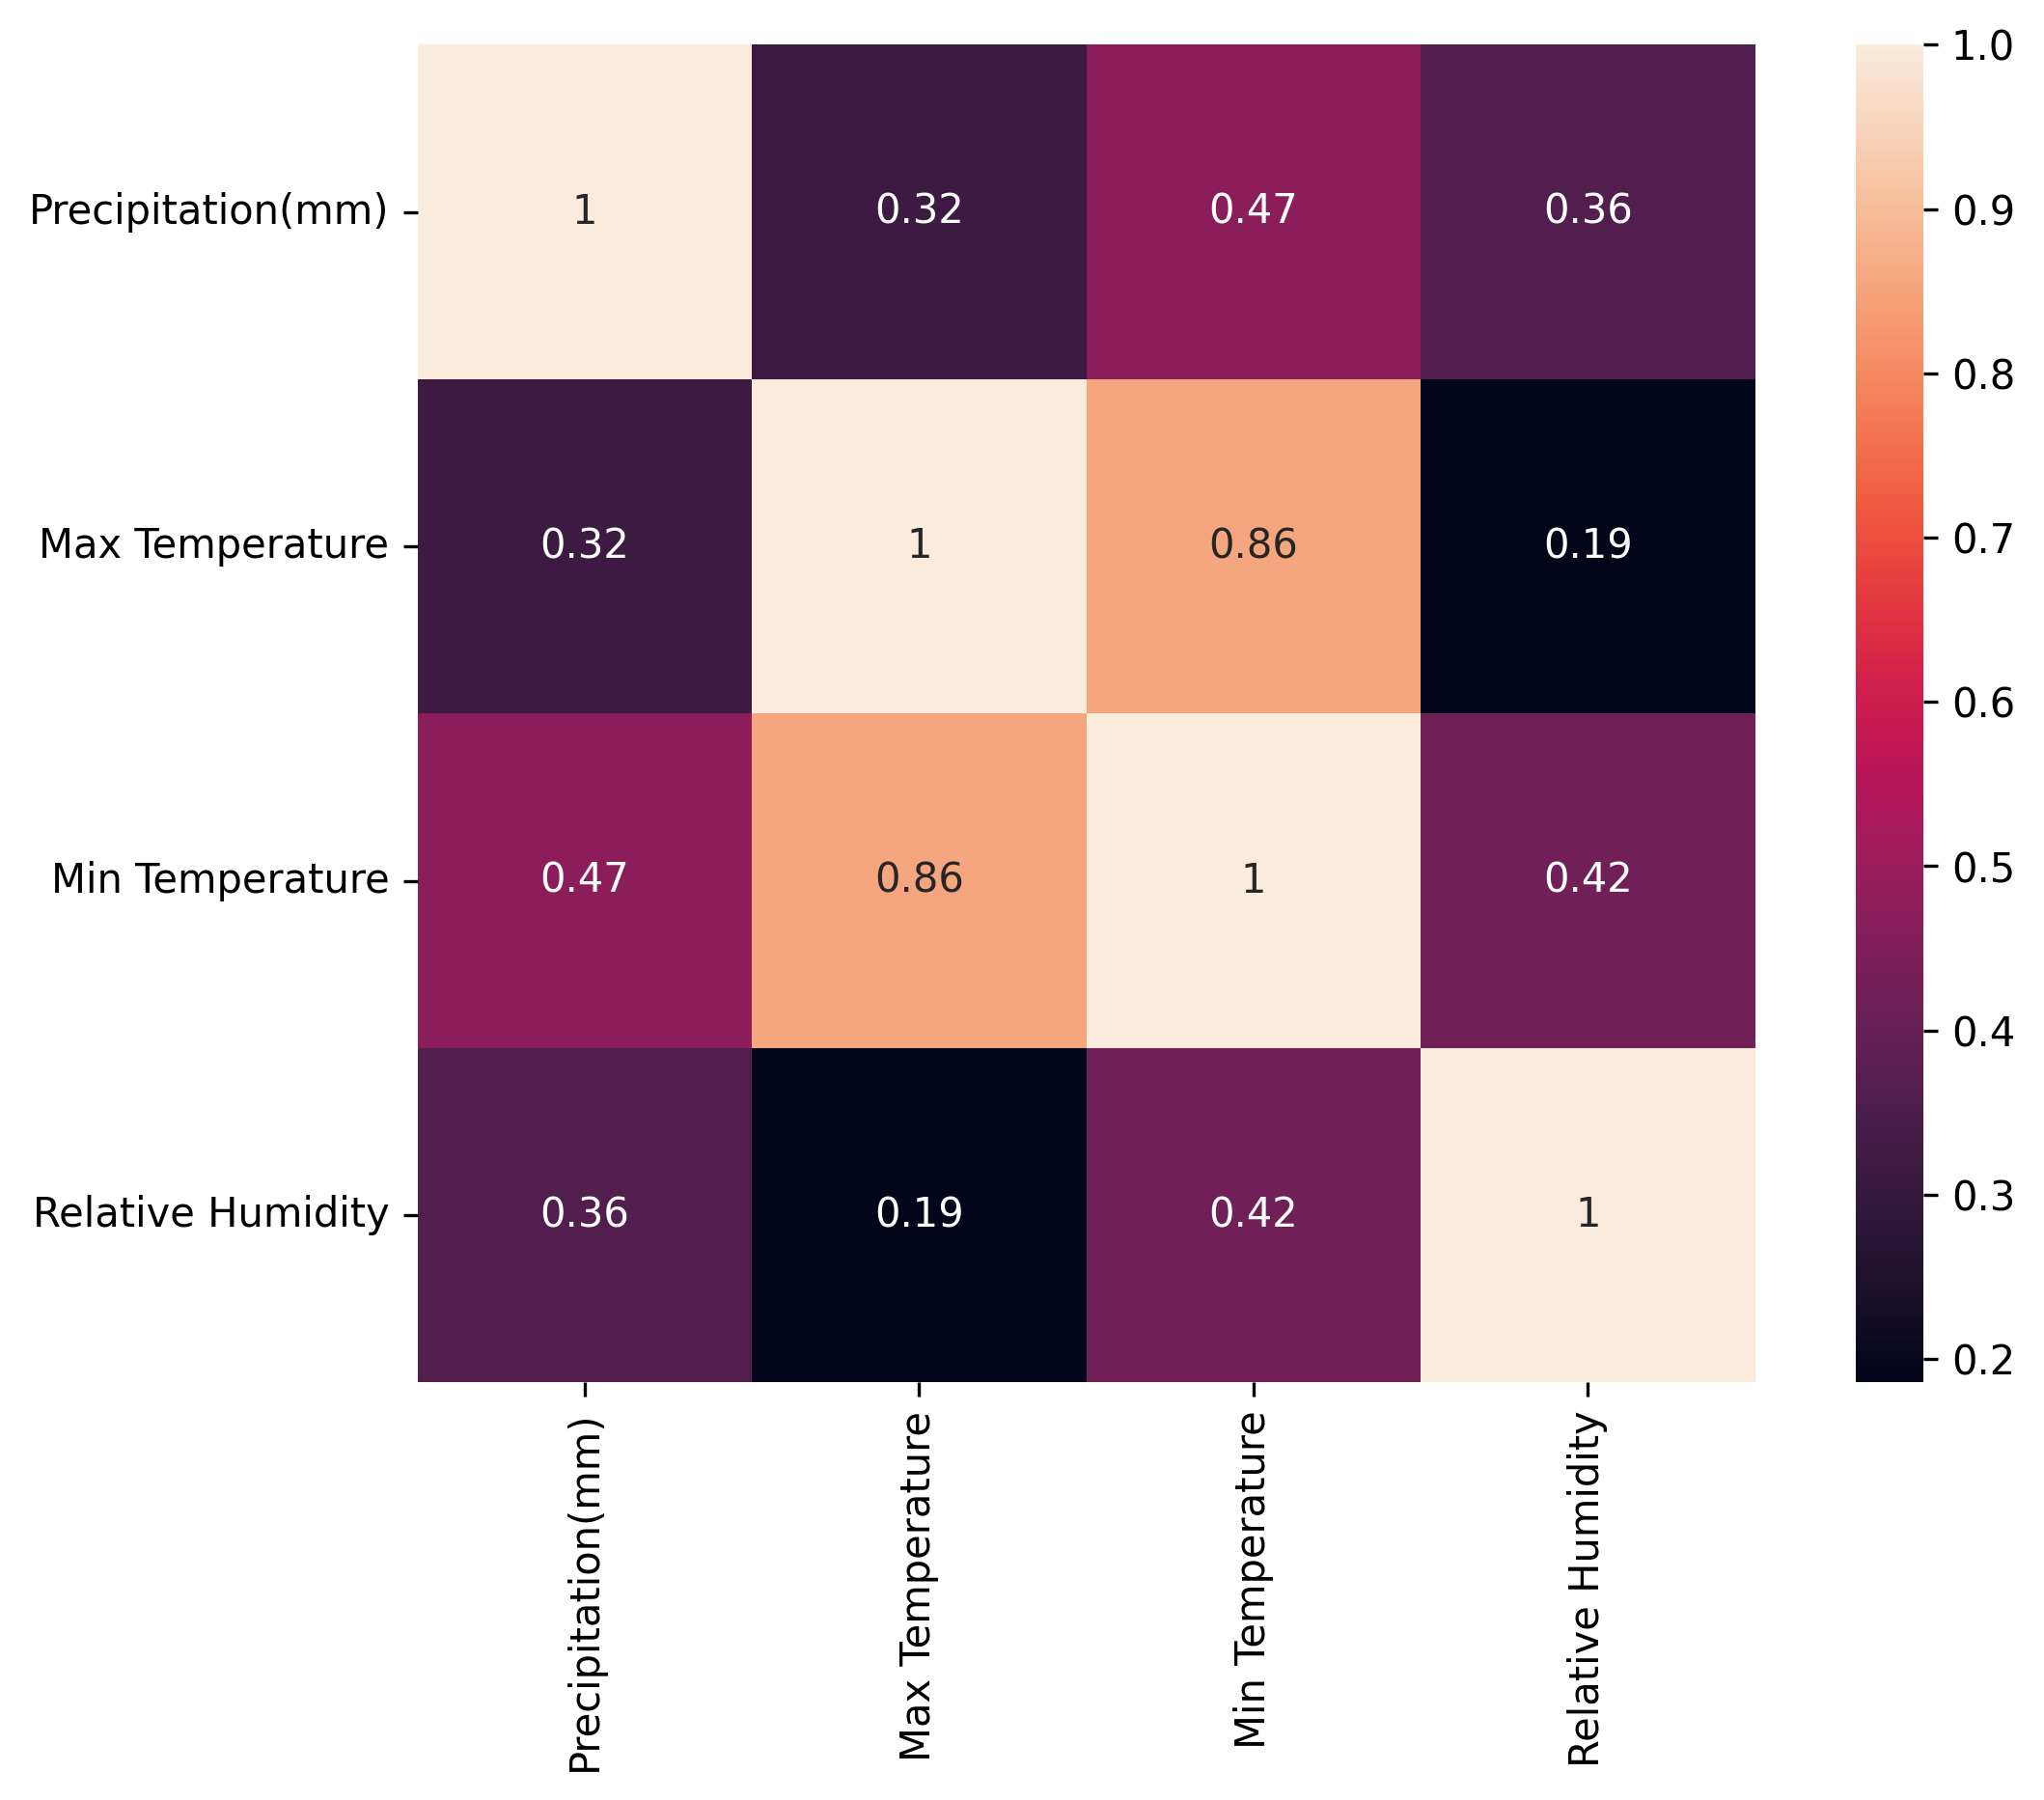

In [5]:
correlation_matrix = data.corr()
fig = plt.figure(figsize=(9,6),dpi=300)
sns.heatmap(correlation_matrix,vmax=1,square = True, annot= True)
plt.show()

In [6]:
train_dates=pd.to_datetime(data['Date'])

# Creating the lag features, so that model will capture the periodicity

In [7]:
#mentioned 2 lags for the precipitation
for i in [1]:
    data["lag_f{}".format(i)] = data['Max Temperature'].shift(periods=i)

data['lag_f1']=data['lag_f1'].fillna(0)
# data['lag_f2']=data['lag_f2'].fillna(0)
# data['lag_f3']=data['lag_f3'].fillna(0)

# data[['Precipitation(mm)', 'lag_f1', 'lag_f2', 'lag_f3' ]]

In [8]:
data[:10]

,Date,Precipitation(mm),Max Temperature,Min Temperature,Relative Humidity,lag_f1
0,2010-01-01,0.0,12.5,3.0,82.15,0.0
1,2010-01-02,0.0,15.5,2.8,76.90,12.5
2,2010-01-03,0.0,15.5,4.8,86.65,15.5
3,2010-01-04,0.0,13.0,4.8,79.45,15.5
4,2010-01-05,0.0,13.8,4.2,75.70,13.0
5,2010-01-06,0.0,16.0,4.5,81.60,13.8
6,2010-01-07,0.0,16.5,5.0,82.60,16.0
7,2010-01-08,0.0,17.5,6.3,85.25,16.5
8,2010-01-09,0.0,17.5,5.3,85.25,17.5
9,2010-01-10,0.0,17.0,4.8,79.65,17.5


In [10]:
data.to_csv('LumleMaxTemperature.csv')

In [11]:
#drop the day of week and month column
# new_df = data.drop(['Date','day_of_week', 'month'], axis=1)
new_df = data.drop(['Date'], axis=1)


In [12]:
new_df.isnull().sum()

Precipitation(mm)    0
Max Temperature      0
Min Temperature      0
Relative Humidity    0
lag_f1               0
dtype: int64

In [13]:
#splitting training testing dataset
X_train, X_test, y_train, y_test = train_test_split(new_df, new_df['Max Temperature'], test_size = 0.2, shuffle = False)
     

In [14]:
y_train[:5]

0    12.5
1    15.5
2    15.5
3    13.0
4    13.8
Name: Max Temperature, dtype: float64

#To normalize the data into the same differences

In [15]:
#Normalize the data and  change into array and reshape to fit the LSTM model
scaler = MinMaxScaler()

#normalize the train and test dataset
X_train_arr=scaler.fit_transform(X_train)
X_test_arr=scaler.transform(X_test)

#reshaping it into the single column data 
y_train_arr=scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_test_arr=scaler.transform(np.array(y_test).reshape(-1,1))

trainX = X_train_arr.reshape((X_train_arr.shape[0], 1 ,X_train_arr.shape[1]))
trainY = y_train_arr.reshape((y_train_arr.shape[0], 1, y_train_arr.shape[1]))

testX= X_test_arr.reshape((X_test_arr.shape[0], 1 ,X_test_arr.shape[1]))
testY = y_test_arr.reshape((y_test_arr.shape[0], 1, y_test_arr.shape[1]))

# Building Model

In [16]:
#Building the model
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(512, input_shape=((1,5)), activation='tanh', return_sequences=True),
  tf.keras.layers.LSTM(32, activation='tanh'),
  tf.keras.layers.Dense(1)
  ])




In [17]:
  # Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)


  # Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 512)            1060864   
                                                                 
 lstm_1 (LSTM)               (None, 32)                69760     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,130,657
Trainable params: 1,130,657
Non-trainable params: 0
_________________________________________________________________


In [18]:
model_history = model.fit(trainX, trainY, batch_size=5, validation_data=(testX,testY), epochs=10)

Epoch 1/10
777/777 [==============================] - 29s 32ms/step - loss: 0.0162 - val_loss: 0.0115
Epoch 2/10
777/777 [==============================] - 22s 28ms/step - loss: 0.0093 - val_loss: 0.0064
Epoch 3/10
777/777 [==============================] - 22s 28ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 4/10
777/777 [==============================] - 20s 26ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 5/10
777/777 [==============================] - 14s 18ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 6/10
777/777 [==============================] - 14s 18ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 7/10
777/777 [==============================] - 14s 18ms/step - loss: 8.6019e-04 - val_loss: 8.7620e-04
Epoch 8/10
777/777 [==============================] - 15s 19ms/step - loss: 7.5131e-04 - val_loss: 7.8339e-04
Epoch 9/10
777/777 [==============================] - 14s 18ms/step - loss: 6.7562e-04 - val_loss: 6.8278e-04
Epoch 10/10
777/777 [==============================] - 15s

# Loss in Training and Validation over the different epoches


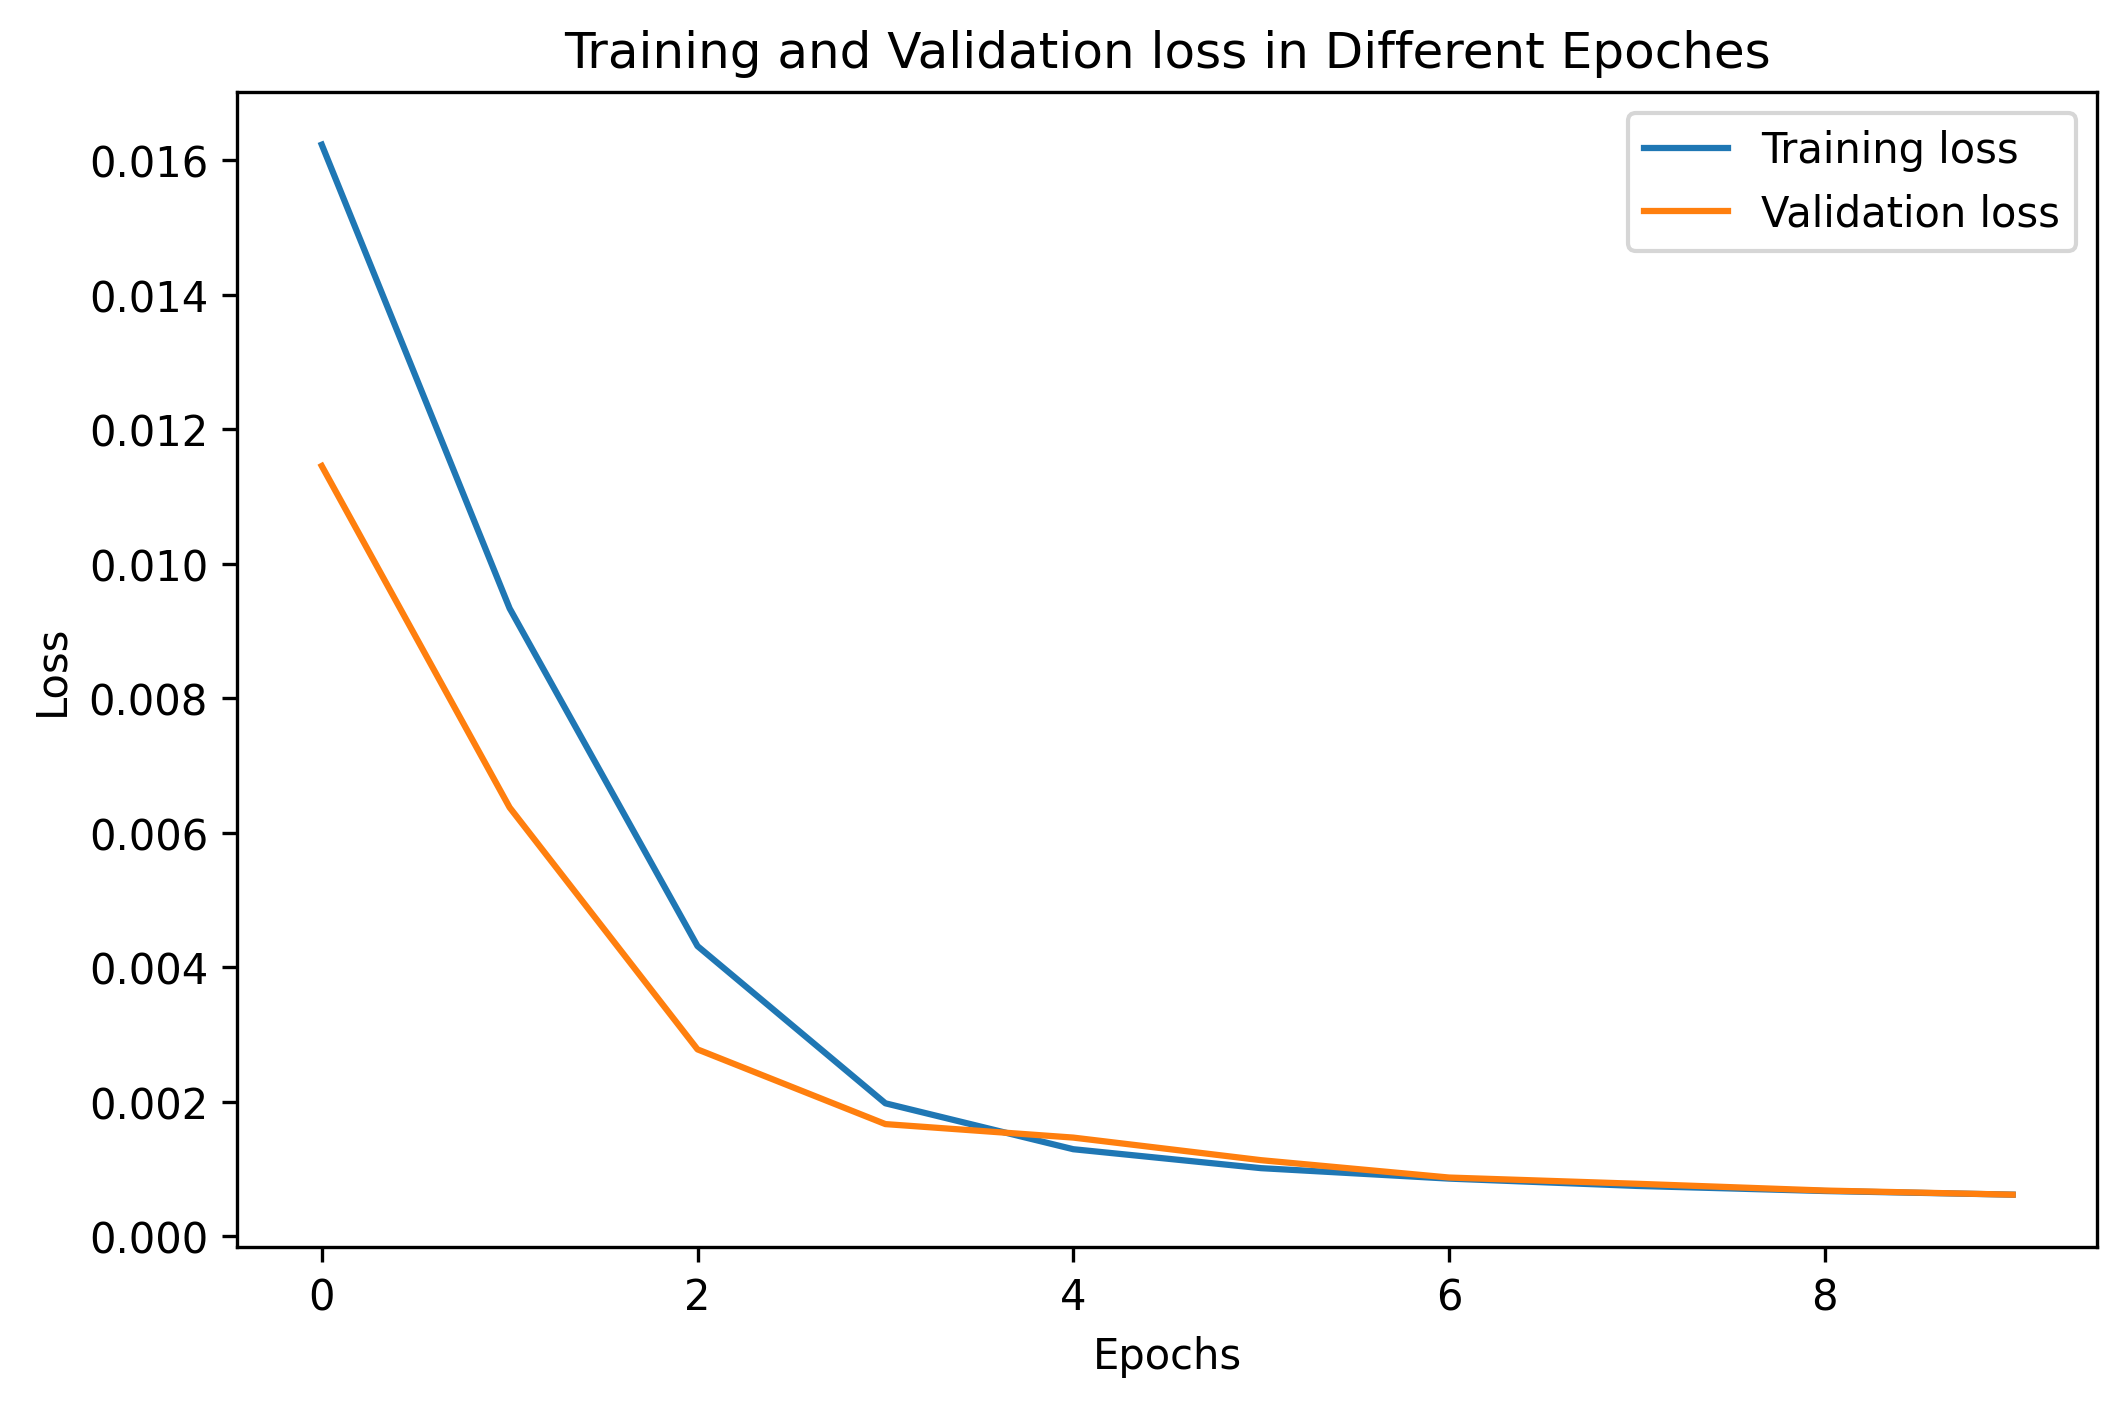

In [19]:
#to plot the loss over the training and validation epoch we can do now as 
history_df = pd.DataFrame(model_history.history)
plt.figure(figsize=(8,5), dpi=300)
plt.plot(history_df.loc[:, ['loss']], label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']], label='Validation loss')
plt.title('Training and Validation loss in Different Epoches')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

# Plotting the Predicted and Actual Graphs and Evaluations

Text(0.5, 1.0, 'Lumle Max Temperature Actual Data Vs Predicted Data')

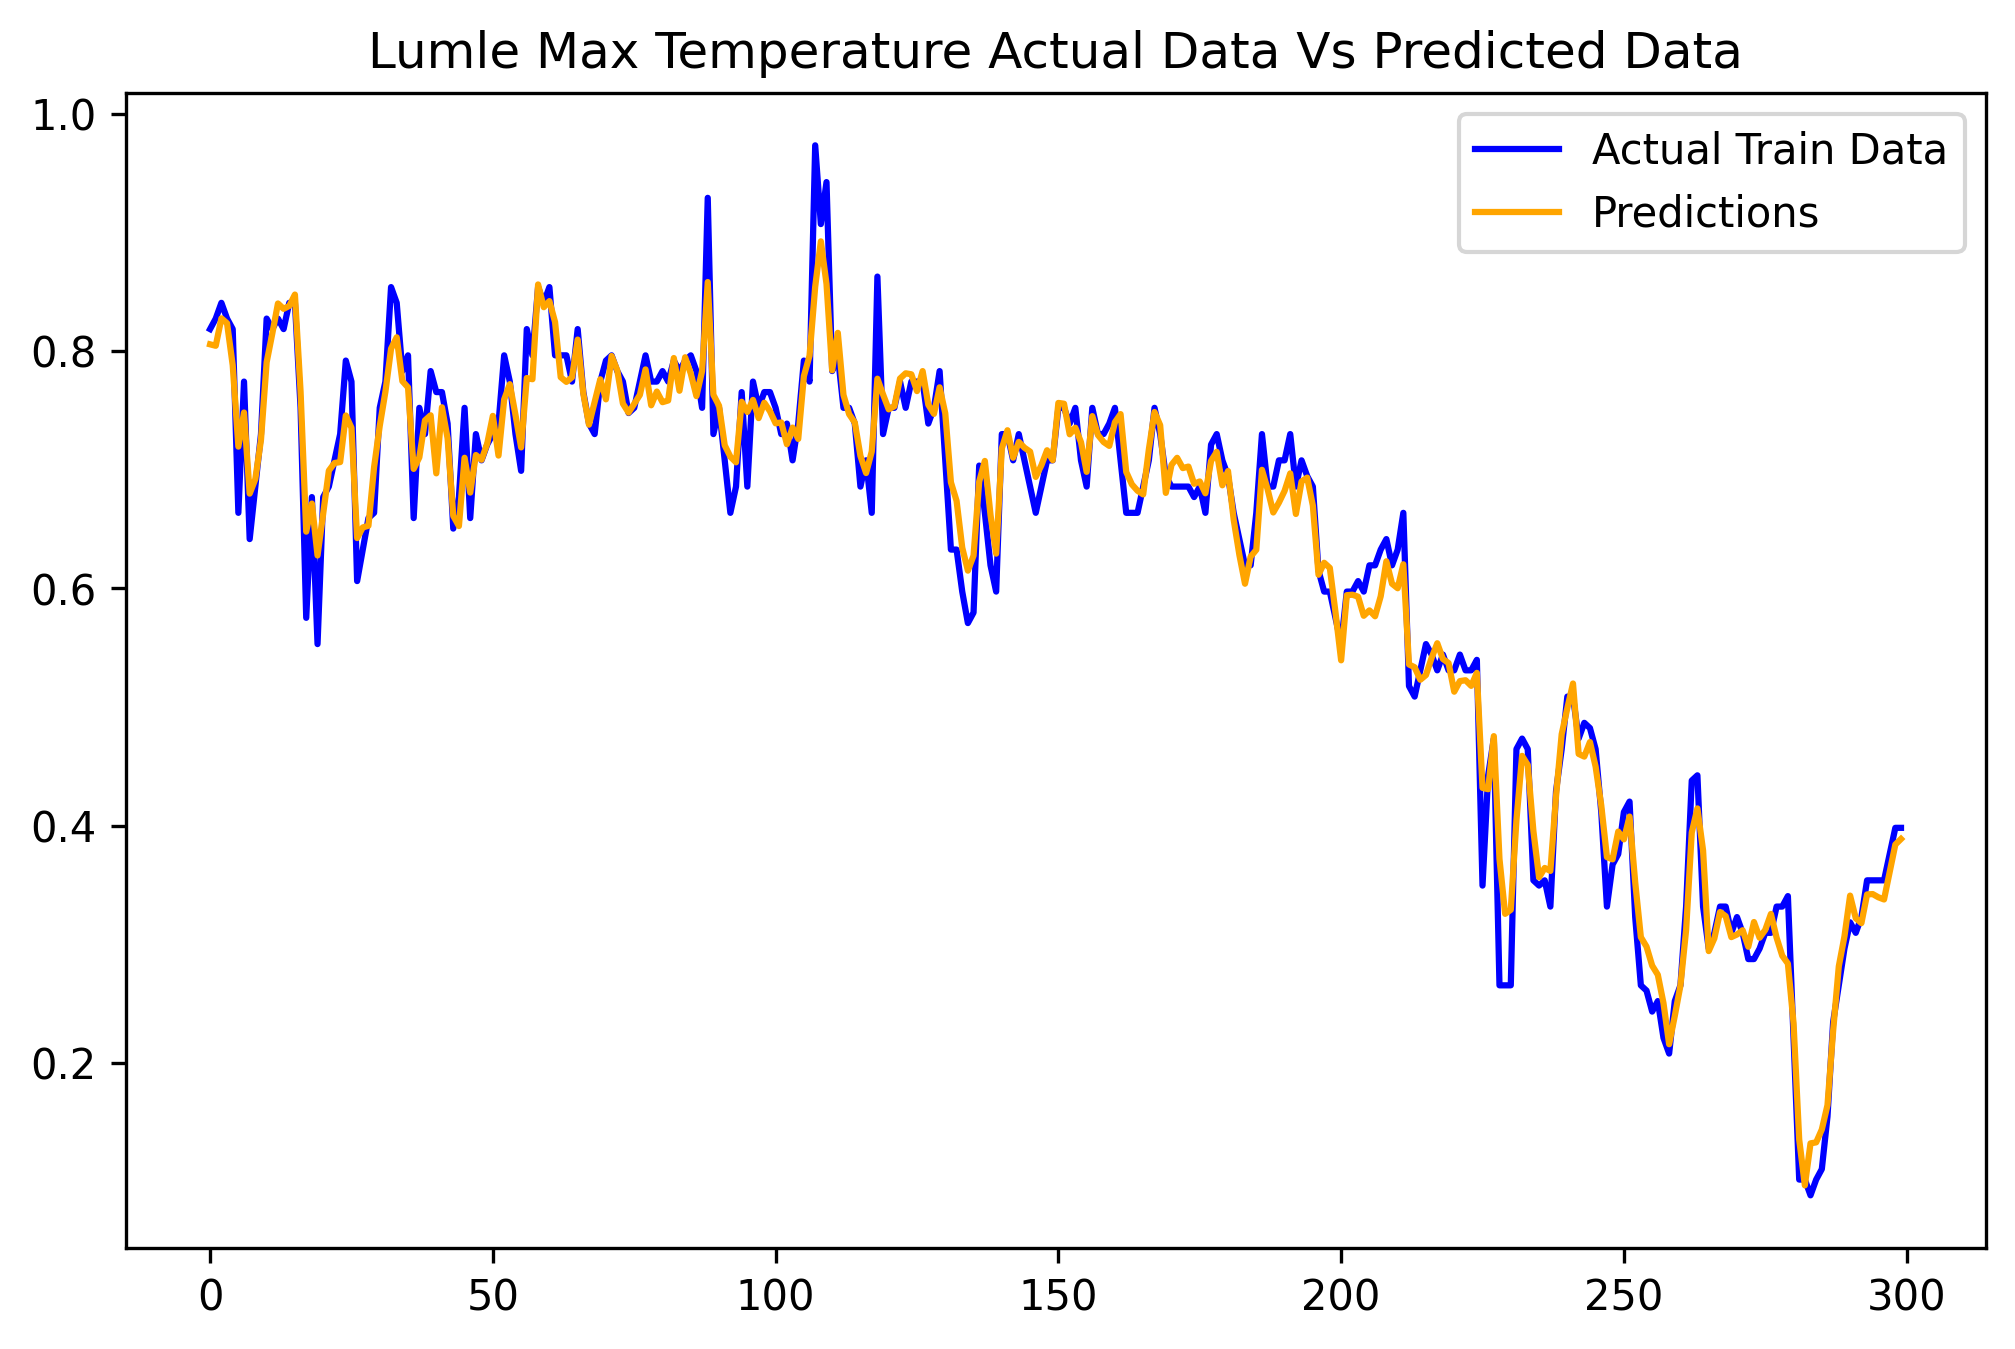

In [20]:
#Plotting the Predicted  vs Real Data  of Triaining Data| Training Accuracy
yPredict_train =model.predict(trainX, verbose=0)

fig,ax = plt.subplots(figsize=(8,5), dpi=300)

ax.plot(y_train_arr[100:400], color='blue', linewidth=1.5, label = "Actual Train Data")
ax.plot(yPredict_train[100:400], color='orange',linewidth=1.5,label = "Predictions")

ax.legend()
ax.set_title('Lumle Max Temperature Actual Data Vs Predicted Data')

Text(0.5, 1.0, 'Lumle Max Temperature Actual Data Vs Predicted Data')

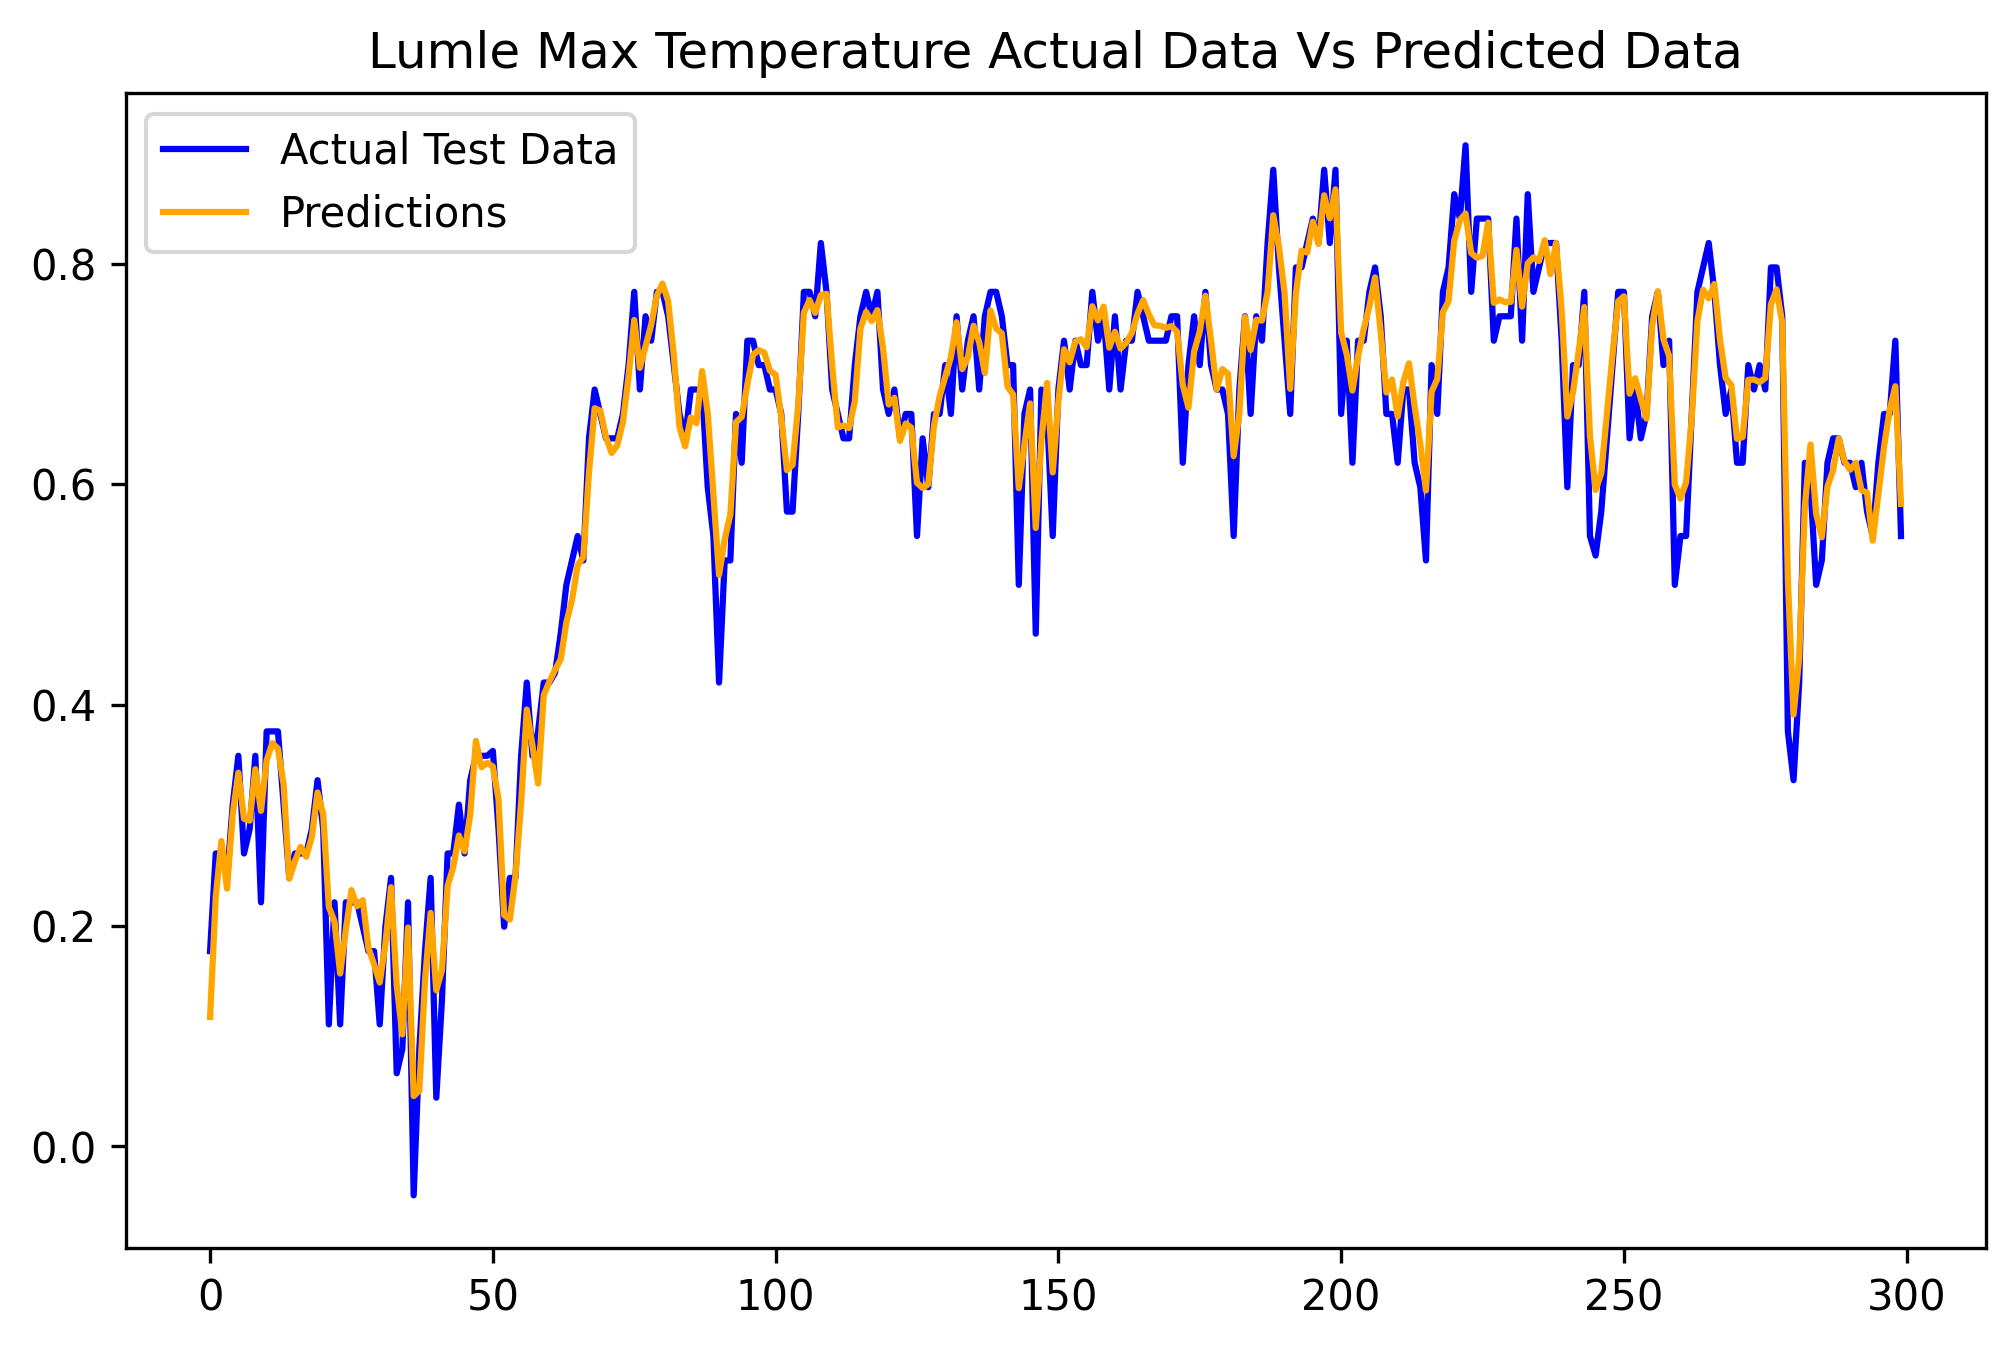

In [21]:
#Plotting the Predicted vs Testing accuracy aspect
yPredict_train =model.predict(testX, verbose=0)


import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(8,5), dpi=300)

ax.plot(y_test_arr[500:800], color='blue', linewidth=1.5, label = "Actual Test Data")
ax.plot(yPredict_train[500:800], color='orange',linewidth=1.5,label = "Predictions")

ax.legend()
ax.set_title('Lumle Max Temperature Actual Data Vs Predicted Data')

#Calculating RMSE and Accuracy of Model

In [22]:
def Evaluation(train, train_pred, test, test_pred):
  # calculate root mean squared error
  train_rmse = np.sqrt(mean_squared_error(train, train_pred))
  print('Train RMSE: %.2f' % (train_rmse))
  test_rmse = np.sqrt(mean_squared_error(test, test_pred))
  print('Test RMSE: %.2f' % (test_rmse))

  # calculate root mean absolute error
  train_mae = mean_absolute_error(train, train_pred)
  print('Train MAE: %.2f' % (train_mae))
  test_mae = mean_absolute_error(test, test_pred)
  print('Test MAE: %.2f' % (test_mae))

  # Calculate r2_score
  train_r2 = r2_score(train, train_pred)
  print('Train r2 score: %.2f' % (train_r2))
  test_r2 = r2_score(test, test_pred)
  print('Test r2 score: %.2f' % (test_r2))

In [23]:
yPredict_train = model.predict(trainX, verbose=0)
yPredict_test = model.predict(testX, verbose=0)

Denormalize_yPredict_train = scaler.inverse_transform(yPredict_train)
Denormalize_trainY = scaler.inverse_transform(y_train_arr)
Denormalize_yPredict_test = scaler.inverse_transform(yPredict_test)
Denormalize_testY = scaler.inverse_transform(y_test_arr)

In [24]:
Evaluation(Denormalize_trainY, Denormalize_yPredict_train, Denormalize_testY, Denormalize_yPredict_test)

Train RMSE: 0.77
Test RMSE: 0.80
Train MAE: 0.59
Test MAE: 0.61
Train r2 score: 0.96
Test r2 score: 0.96


In [25]:
Denormalize_testY.shape

(971, 1)

In [26]:
#make it into one column data so that concat will be easy
Predicted=Denormalize_yPredict_test.reshape(-1)
Actual=Denormalize_testY.reshape(-1)

In [27]:
#Concatination the result 
test_results=pd.DataFrame(data={'Max Temp Predictions':Predicted, 'Actuals': Actual})
test_results

,Max Temp Predictions,Actuals
0,25.372505,25.5
1,23.839176,22.0
2,23.261658,23.0
3,24.832771,25.0
4,24.403381,24.5
...,...,...
966,23.117765,23.0
967,23.694139,24.0
968,23.941124,24.5
969,25.175545,25.5


 # Tomorrow Prediction

In [28]:
next_day_predict=model.predict(testX[-1:])
next_day=scaler.inverse_transform(next_day_predict)
next_day

1/1 [==============================] - 0s 24ms/step


array([[25.641241]], dtype=float32)

In [29]:
# save the model to a file in .h5 format
model.save('model/LumleMaxTempmodel.h5')

In [30]:
import pickle
# save the model and scaler to a file
with open('/content/model/LumleMaxTempmodel.pkl', 'wb') as f:
    pickle.dump(model, f)